# Movielens
---
Esta base de datos contiene información sobre películas y ratings de distintos usuarios.
Responde a las siguientes preguntas

<div class="panel panel-danger">
    <div class='panel-heading'>
    <h4>Antes de empezar</h4>
    </div>
    <div class='panel-body'>
    <p>Para poder ejecutar queries a la base de datos, necesitamos tener instalado antes el paquete [ipython-sql](https://github.com/catherinedevlin/ipython-sql).
    
    <p>Este paquete nos permite escribir las queries sql en las celdas del notebook y visualizar el resultado como tablas html renderizadas
    <p>Ejecuta `!pip install ipython-sql` si es la primera vez que usas este notebook
    </div>
</div>

In [1]:
!pip install ipython-sql

**Cargamos la base de datos ** 

In [1]:
%load_ext sql
%sql sqlite:///data/movies/movielens.sqlite
%sql SELECT name FROM sqlite_master WHERE type='table'

Done.


name
ratings
links
tags
movies


Antes de empezar, recuerda que para ejecutar una query sql en las celdas de los notebooks, debes empezar la celda por `%%sql`. Por ejemplo...

In [2]:
%%sql

SELECT count(*) as num_rows
FROM movies

Done.


num_rows
9125


Recuerda que también puedes realizar queries a la base de datos usango `pandas` y `sqlite3`

---
<div class="panel panel-success">
    <div class='panel-heading'>
    <h4>Empecemos</h4>
    </div>
    <div class='panel-body'>
    <p> Responde a las siguientes preguntas de la base de datos
    </div>
</div>

**1. Nombra las columnas de cada tabla en la base de datos e identifíca las *primary* y *foreign* keys **

Versió 1. Així també tenim l'_schema_.

In [3]:
%%sql
SELECT name, sql
FROM sqlite_master 
WHERE type='table'

Done.


name,sql
ratings,"CREATE TABLE ""ratings"" (""index"" INTEGER, ""userId"" INTEGER, ""movieId"" INTEGER, ""rating"" REAL, ""timestamp"" TIMESTAMP)"
links,"CREATE TABLE ""links"" (""index"" INTEGER, ""movieId"" INTEGER, ""imdbId"" INTEGER, ""tmdbId"" REAL)"
tags,"CREATE TABLE ""tags"" (""index"" INTEGER, ""userId"" INTEGER, ""movieId"" INTEGER, ""tag"" TEXT, ""timestamp"" TIMESTAMP)"
movies,"CREATE TABLE ""movies"" (""index"" INTEGER, ""movieId"" INTEGER, ""title"" TEXT, ""genres"" TEXT)"


Versió 2. Pas a pas.

In [4]:
%sql SELECT * FROM ratings LIMIT 0

Done.


index,userId,movieId,rating,timestamp


Primary key: rating.

In [5]:
%sql SELECT * FROM links LIMIT 0

Done.


index,movieId,imdbId,tmdbId


Primary key: ?

In [6]:
%sql SELECT * FROM tags LIMIT 0

Done.


index,userId,movieId,tag,timestamp


Primary key: tag.

In [7]:
%sql SELECT * FROM movies LIMIT 0

Done.


index,movieId,title,genres


Primary key: movieId.

**2. ¿Cómo evolucion el rating de '12 Angry Men' a lo largo de los años? Haz un gráfico de la evolución**

In [8]:
%%sql
SELECT movieId, title
FROM movies
WHERE title LIKE('%12 Angry Men%')

Done.


movieId,title
1203,12 Angry Men (1957)
77846,12 Angry Men (1997)


In [9]:
import pandas as pd
import sqlite3

conn = sqlite3.connect('data/movies/movielens.sqlite')

query = """
SELECT movieId,
       rating, 
       timestamp
FROM ratings
WHERE movieId= (SELECT movieId
                  FROM movies
                  WHERE title LIKE('%12 Angry Men%')
                  LIMIT 1) 
    OR movieId= (SELECT movieId
                  FROM movies
                  WHERE title LIKE('%12 Angry Men%')
                  LIMIT 1 OFFSET 1) 
"""

AM_rating = pd.read_sql(query, conn)
AM_rating.tail()

,movieId,rating,timestamp
73,1203,4.0,2008-04-15 22:17:18
74,1203,4.0,2001-10-16 17:42:27
75,77846,4.0,2013-01-09 09:55:13
76,1203,4.5,2012-07-24 15:10:17
77,1203,5.0,2001-04-02 20:10:41


In [10]:
AM_rating['timestamp'] = pd.to_datetime(AM_rating['timestamp'])
AM_rating = AM_rating.set_index(AM_rating['timestamp'])
AM_rating  = AM_rating.drop('timestamp', axis=1)
AM_rating = AM_rating.sort_index()
AM_rating.head()

,movieId,rating
timestamp,,
1996-12-16 09:13:53,1203,4.0
1997-01-21 12:46:31,1203,4.0
1997-01-22 00:48:20,1203,5.0
1997-02-06 01:15:02,1203,4.0
1997-04-09 04:44:43,1203,4.0


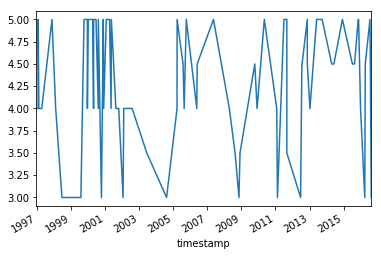

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
AM_rating['rating'].plot()

** 3. ¿Cuál es la película peor valorada de cada año? **

Prova amb un any. <br>
ALERTA! Al posar Limit 1, si el menor rating està repetit ens quedarem només amb una pel·lícula.

In [12]:
%%sql
SELECT r.movieId,
        m.title,
        AVG(r.rating) as avg_rating,
        strftime('%Y',timestamp) as year
FROM ratings as r
INNER JOIN movies as m
ON r.movieId = m.movieId
WHERE year='2000'
GROUP BY r.movieId
ORDER BY avg_rating ASC
LIMIT 1

Done.


movieId,title,avg_rating,year
15,Cutthroat Island (1995),1.0,2000


In [13]:
query_years = """
SELECT DISTINCT(strftime('%Y',timestamp)) as year
FROM ratings
ORDER BY strftime('%Y',timestamp) ASC
"""
years_unique = pd.read_sql(query_years, conn)

In [14]:
list_df = []
for year in years_unique['year'].values:
    query = """
            SELECT r.movieId,
                    m.title,
                    AVG(r.rating) as avg_rating,
                    strftime('%Y',timestamp) as time_year
            FROM ratings as r
            INNER JOIN movies as m
            ON r.movieId = m.movieId
            WHERE time_year='{y}'
            GROUP BY r.movieId
            ORDER BY avg_rating ASC
            LIMIT 1
            """.format(y=year)
    df = pd.read_sql(query, conn)
    list_df.append(df)
    
pd.concat(list_df)

,movieId,title,avg_rating,time_year
0,21,Get Shorty (1995),3.0,1995
0,42,Dead Presidents (1995),1.0,1996
0,24,Powder (1995),1.0,1997
0,66,Lawnmower Man 2: Beyond Cyberspace (1996),1.0,1998
0,4,Waiting to Exhale (1995),1.0,1999
0,15,Cutthroat Island (1995),1.0,2000
0,8,Tom and Huck (1995),1.0,2001
0,65,Bio-Dome (1996),1.0,2002
0,102,Mr. Wrong (1996),0.5,2003
0,71,Fair Game (1995),0.5,2004


** 4. ¿Quién es el usuario más activo y desde cuándo lleva activo? **

In [15]:
%%sql
SELECT userId,
        COUNT(*) as num_active
FROM ratings
GROUP BY UserId
ORDER BY num_active DESC
LIMIT 1

Done.


userId,num_active
547,2391


** 5. ¿Cuales son sus 5 películas favorítas del año 2016? **

Com seleccionar usuari:

In [16]:
%%sql
SELECT userId
FROM ratings
GROUP BY UserId
ORDER BY COUNT(*) DESC
LIMIT 1

Done.


userId
547


Tot junt.

In [17]:
%%sql
SELECT m.title,
        r.rating,
        r.timestamp
FROM ratings as r
INNER JOIN movies as m 
ON r.movieId = m.movieId
WHERE r.userId= ( SELECT userId
                    FROM ratings
                    GROUP BY UserId
                    ORDER BY COUNT(*) DESC
                    LIMIT 1)
      AND strftime('%Y',r.timestamp)='2016'
ORDER BY r.rating DESC
LIMIT 5

Done.


title,rating,timestamp
Making a Murderer (2015),5.0,2016-02-02 17:03:02
The Beatles: Eight Days a Week - The Touring Years (2016),5.0,2016-10-14 04:27:19
"Lust, Caution (Se, jie) (2007)",4.5,2016-08-30 15:10:39
"Impossible, The (Imposible, Lo) (2012)",4.5,2016-03-12 14:28:34
Ex Machina (2015),4.5,2016-01-28 17:08:05


**6. Haz una gráfica de como evolucionan el número de películas que ve cada año y la nota media. **

In [18]:
query = """
SELECT strftime('%Y',timestamp) as year,
        AVG(rating) as avg_rating, 
        COUNT(DISTINCT movieId) as number_films
FROM ratings
WHERE userId= ( SELECT userId
                    FROM ratings
                    GROUP BY UserId
                    ORDER BY COUNT(*) DESC
                    LIMIT 1)
GROUP BY year
"""
activeUser = pd.read_sql(query, conn)
activeUser = activeUser.set_index(activeUser['year'])
activeUser  = activeUser.drop('year', axis=1)
activeUser = activeUser.sort_index()
activeUser.head()

,avg_rating,number_films
year,,
2000,4.080189,212
2001,3.237500,240
2002,3.018587,269
2003,3.242525,301
2004,2.985149,202


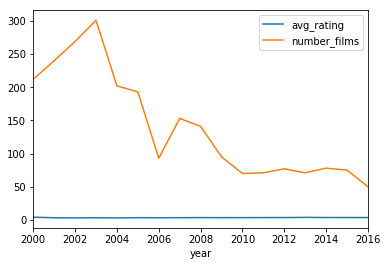

In [19]:
activeUser.plot()

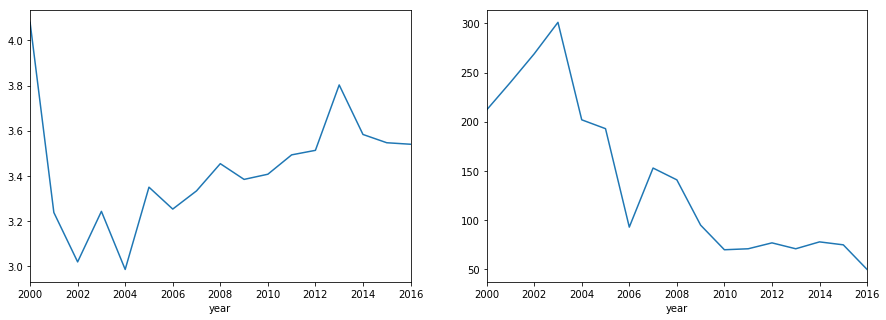

In [28]:
#nrows=2, ncols=1, plot_number=1
plt.figure(figsize=(15,5))

plt.subplot(121)
activeUser['avg_rating'].plot()

plt.subplot(122)
activeUser['number_films'].plot()
